In [1]:
import numpy as np
import jax.numpy as jnp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import casadi as ca


In [ ]:

# --- System parameters ---
m = 1.0  # Mass (kg)
k = 100.0  # Spring stiffness (N/m)
L0 = 1.0  # Spring rest length (m)
g = 9.81  # Acceleration due to gravity (m/s^2)
c = 1.5 # Damping coefficient (N·s/m)

# --- Initial conditions ---
y0 = L0 + 1.0  # Initial height above the floor (m)
v0 = 0.0     # Initial velocity (m/s)

# Time span for the simulation
t_span = (0, 10)  # Start and end time

In [3]:
# --- ODE function defining the system dynamics ---
def hopper_system(t, state, u):
    """
    Defines the system of first-order differential equations.
    state = [y, v], where y is position and v is velocity.
    """
    y = state[0]
    v = state[1]

    # Force calculation
    force_gravity = -m * g
    force_spring = 0.0
    force_damping = 0.0
    force_input = 0.0

    # Spring force is active only when the spring is compressed against the floor
    if y <= L0:
        compression = L0 - y
        force_spring = k * compression
        force_damping = -c * v
        force_input = u

    # Net force and acceleration
    net_force = force_gravity + force_spring + force_damping + force_input
    a = net_force / m

    # Return the derivatives (dy/dt and dv/dt)
    return np.array([v, a])

def control_law(t, state):
    """Simple control law to apply an upward force when the spring is compressed."""
    if state[0] <= L0:
        return 250.0 
    return 0.0

# --- Event function for ground impact ---
def ground_impact(t, state):
    """Event function to detect when the mass hits the ground (y = 0)."""
    return state[0]  

ground_impact.terminal = True  # Stop the integration when the event occurs
ground_impact.direction = -1   # Detect events only when y is decreasing


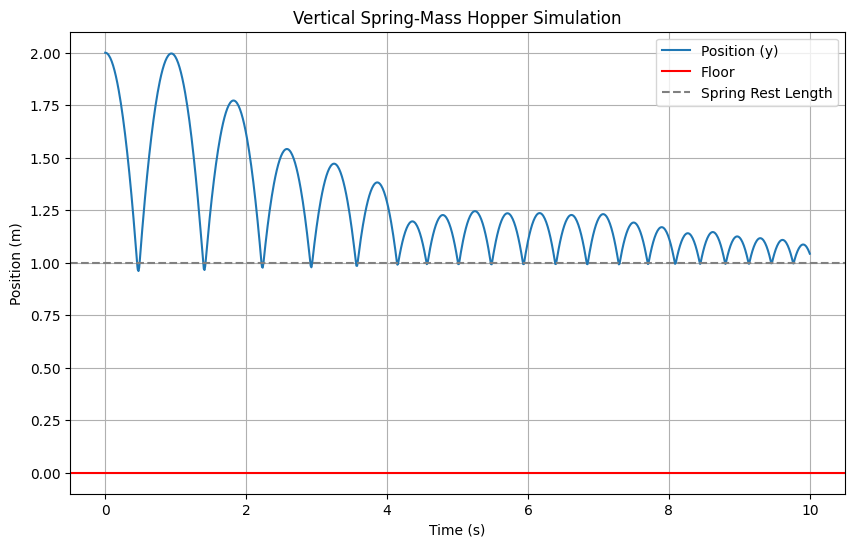

In [4]:
# --- Simulation loop ---
# We use a loop to handle the multiple phases (aerial and ground contact).
time_history = jnp.array([])
position_history = jnp.array([])
velocity_history = jnp.array([])

t0 = t_span[0]
init_state = [y0, v0]

while t0 < t_span[1]:
    # Solve for the next phase, stopping at the ground impact or end time.

    def dynamical_system(t, state):
        u = control_law(t, state)
        return hopper_system(t, state, u)
    
    sol = solve_ivp(
        dynamical_system,
        (t0, t_span[1]),
        init_state,
        events=ground_impact,
        max_step=0.01  # Maximum time step for accuracy
    )
    
    # Append results from this phase
    time_history = jnp.concatenate((time_history, sol.t))
    position_history = jnp.concatenate((position_history, sol.y[0]))
    velocity_history = jnp.concatenate((velocity_history, sol.y[1]))

    # If the simulation stopped due to a ground impact event
    if sol.t_events[0].size > 0:
        impact_time = sol.t_events[0][0]
        impact_velocity = sol.y[1][-1]

        # The mass bounces back with a reverse velocity (no energy loss assumed)
        current_state = [0.0, -impact_velocity]
        current_t_start = impact_time
    else:
        break # End of simulation time

# --- Visualization ---
plt.figure(figsize=(10, 6))
plt.plot(time_history, position_history, label='Position (y)')
plt.title('Vertical Spring-Mass Hopper Simulation')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.axhline(y=0, color='r', label='Floor')
plt.axhline(y=L0, color='grey', linestyle='--', label='Spring Rest Length')
plt.grid(True)
plt.legend()
plt.show()

Let's try discretizing instead of solve_ivp

Discrete time dynamics

In [5]:
def f(state, u):
    """Discrete dynamics update for the hopper system."""
    y, v = state

    # Force calculation
    force_gravity = -m * g
    force_spring = 0.0
    force_damping = 0.0
    force_input = 0.0

    # Spring force is active only when the spring is compressed against the floor
    if y <= L0:
        compression = L0 - y
        force_spring = k * compression
        force_damping = -c * v
        force_input = u

    # Net force and acceleration
    net_force = force_gravity + force_spring + force_damping + force_input
    a = net_force / m

    # # Update state using Euler integration
    # v_new = v + a
    # y_new = y + v_new * dt

    return jnp.array([v, a])

def kappa(state):
    """Simple control law to apply an upward force when the spring is compressed."""
    if state[0] <= L0:
        return 50.0  
    return 0.0

Simulation loop:

In [6]:
def simulate_discrete(dt=0.001, t_max=10.0):
    """Discrete simulation with explicit Euler integration."""
    
    # Initialize
    t = 0.0
    y = y0
    v = v0
    
    # Storage
    time_hist = [t]
    pos_hist = [y]
    vel_hist = [v]
    
    while t < t_max:

        u = kappa([y, v])

        y, v = jnp.array([y, v]) + f([y, v], u)*dt
        t += dt
        
        # Store
        time_hist.append(t)
        pos_hist.append(y)
        vel_hist.append(v)
    
    return jnp.array(time_hist), jnp.array(pos_hist), jnp.array(vel_hist)

In [7]:

y0 = L0 + 2.0  # Initial height above the floor (m)
v0 = 0.0     # Initial velocity (m/s)
dt = 0.001

print(1/dt)

time_hist, pos_hist, vel_hist = simulate_discrete(dt, 5.0)

1000.0


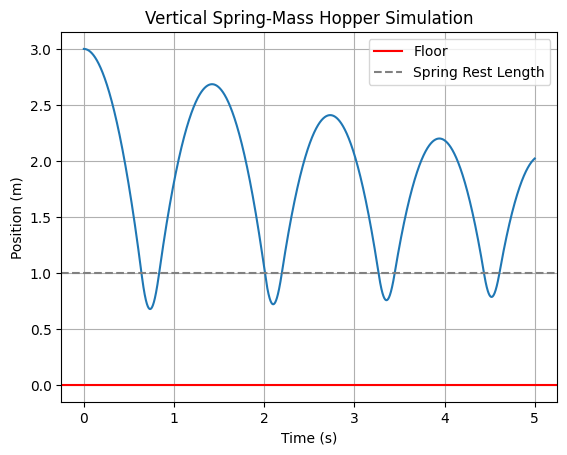

In [8]:
plt.plot(time_hist, pos_hist)
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title('Vertical Spring-Mass Hopper Simulation')
plt.axhline(y=0, color='r', label='Floor')
plt.axhline(y=L0, color='grey', linestyle='--', label='Spring Rest Length')
plt.grid(True)
plt.legend()
plt.show()


Animate hopper system

In [9]:
import matplotlib.animation as animation
import os

def animate(x_hist,
            save_path="animations/hopper_bounce.gif",
            fps=20):

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_ylabel("Height (m)")
    ax.set_title('Vertical Spring-Mass Hopper Simulation')
    ax.axhline(y=0, color='r', label='Floor')
    # ax.axhline(y=L0, color='grey', linestyle='--', label='Spring Rest Length')
    ax.grid(True,zorder=0)
    ax.legend()
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_xlim(-1,1)
    ax.set_ylim(0,max(pos_hist)+1)
    ax.set_aspect('equal')

    # Initialize the mass circle
    radius = 0.1
    mass_circle = plt.Circle((0, x_hist[0, 0]), radius, color='red')
    ax.add_patch(mass_circle)

    # Initialize the spring
    spring_line = plt.Line2D([0, 0], [0, x_hist[0, 0]], color='black', linewidth=4)
    ax.add_line(spring_line)

    # Add invisible elements for legend
    ax.plot([], [], 'ro', markersize=10, label='Mass')  # Invisible red circle for legend

    def animate(frame):
        # Update mass position
        x_current = x_hist[:, frame]
        mass_circle.center = (0, x_current[0])

        # Update spring
        compression = L0 - x_current[0]
        if compression > 0:
            spring_line.set_data([0, 0], [0, (x_current[0]-(compression/2))])
        else:
            spring_line.set_data([0, 0], [x_current[0]-L0, x_current[0]-radius])
        return [mass_circle, spring_line]


    # Create animation with every 5th frame
    frame_skip = 50
    frames = range(0, len(time_hist), frame_skip)

    anim = animation.FuncAnimation(
        fig, 
        animate, 
        frames=frames,
        interval=1000/fps,  # 50ms between frames = 20 FPS
        blit=True,
        repeat=True
    )

    # Create animations directory if it doesn't exist
    animation_dir = "animations"
    os.makedirs(animation_dir, exist_ok=True)

    # Save GIF to the animations directory
    print(f"Saving animation to {save_path}...")
    anim.save(save_path, writer='pillow', fps=fps, dpi=100)
    print("Animation saved!")

    plt.show()

Saving animation to animations/hopper_bounce.gif...
Animation saved!


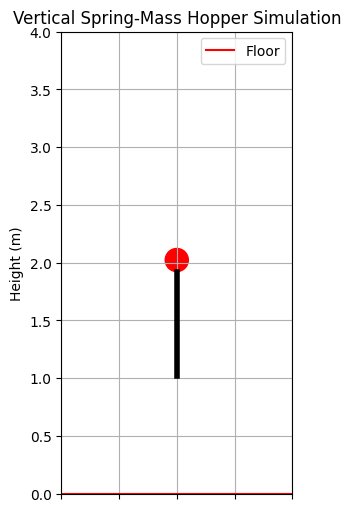

In [10]:
x_hist = jnp.vstack((pos_hist, vel_hist))
animate(x_hist, save_path="animations/hopper_bounce.gif",fps=20)

Try MPC

In [ ]:
from pyparsing import Dict
import casadi as ca

class MPC:

    def __init__(
            self,
            N: int,         # horizon length
            f: callable,    # x(k+1) = f(x,u)
            J: callable,    # cost function
            n: int,         # state dimension
            m: int,         # input dimension
            x_constraints: callable = None, # constraints function
            u_constraints: callable = None, # constraints functions
        ) -> None:

        self.N = N
        self.f = f
        self.J = J
        self.x_constraints = x_constraints
        self.u_constraints = u_constraints

        self.n = n
        self.m = m

        # create optimizer container and define its optimization variables
        self.opti = ca.Opti()
        # opti variables are optimized variables, we can only change their initial pre-optimized value at runtime
        self.X = self.opti.variable(n, N+1) # first state plays no role
        self.U = self.opti.variable(m, N) # final input plays no role


        # apply initial condition constraints
        self.init = self.opti.parameter(n,1) # opti parameters are non-optimized variables that we can change at runtime
        self.opti.set_value(self.init, jnp.zeros((n, 1)))
        self.opti.subject_to(self.X[:,0] == self.init)

        # apply dynamics constraints with euler integrator
        for k in range(N):
            self.opti.subject_to(self.X[:,k+1] == self.X[:,k] + f(self.X[:,k], self.U[:,k]))

        # apply state and input constraints
        for k in range(N+1):
            self.opti.subject_to(x_constraints(self.X[:,k]) >= 0)

        for k in range(N):
            self.opti.subject_to(u_constraints(self.U[:,k]) >= 0)

            
        # define objective function
        self.opti.minimize(sum(J(self.X[:,k], self.U[:,k]) for k in range(N)))


        # tell the opti container we want to use IPOPT to optimize, and define settings for the solver
        opts = {
            'ipopt.print_level':0, 
            'print_time':0,
            'ipopt.tol': 1e-6,
        } # silence!
        self.opti.solver('ipopt', opts)
            
        # perform the solve
        sol = self.opti.solve()

        # extract the answer and save to an attribute we will later use to warm start the optimization variables for efficiency
        self.x_sol, self.u_sol = sol.value(self.X), sol.value(self.U)

    def __call__(self, x):

        # assign the new initial condition to the runtime changeable parameter
        self.opti.set_value(self.init, x)

        # warm starting based off of previous solution
        old_x_sol = self.x_sol[:,2:] # ignore old start and first step (this step start)
        x_warm_start = jnp.hstack([old_x_sol, old_x_sol[:,-1:]]) # stack final solution onto the end again for next warm start
        old_u_sol = self.u_sol[:,1:] # ignore previous solution
        u_warm_start = jnp.hstack([old_u_sol, old_u_sol[:,-1:]]) # stack final u solution onto the end again for next warm start

        self.opti.set_initial(self.X[:,1:], x_warm_start)
        self.opti.set_initial(self.U[:,:], u_warm_start) 

        # perform the solve
        sol = self.opti.solve()

        # extract the answer
        self.x_sol, self.u_sol = sol.value(self.X), sol.value(self.U)

        # return first input to be used
        return self.u_sol[:,0]
    
    def get_predictions(self):
        return self.opti.value(self.X), self.opti.value(self.U)
    

In [12]:
def f(state, u):
    """Discrete dynamics update for the hopper system."""
    y = state[0]
    v = state[1]

    # Force calculation
    force_gravity = -m * g
    
    # Use CasADi conditional functions instead of Python if statements
    compression = L0 - y
    force_spring = ca.if_else(y <= L0, k * compression, 0.0)
    force_damping = ca.if_else(y <= L0, -c * v, 0.0)
    force_input = ca.if_else(y <= L0, u[0], 0.0)  # u is a vector, access first element

    # Net force and acceleration
    net_force = force_gravity + force_spring + force_damping + force_input
    a = net_force / m

    return ca.vertcat(v, a)

# Fix the cost function - remove NumPy matrix operations
def J(x, u):
    """CasADi-compatible cost function."""
    y_ref = 2.0
    
    # Use scalar operations instead of matrix operations
    position_cost = 10.0 * x[0]**2
    velocity_cost = 0.0 * x[1]**2
    reference_cost = (x[0] - y_ref)**2
    control_cost = 0.1 * u[0]**2
    
    return position_cost + velocity_cost + reference_cost + control_cost
x_constraints = lambda x: ca.vertcat(x[0]-0.0, 10.0 - x[0], x[1]+10.0, 10.0 - x[1])
u_constraints = lambda u: ca.vertcat(u[0]-0.0, 100.0 - u[0])

In [15]:
# test MPC class

N = 30
dt = 0.1
mpc = MPC(
    N,
    f,
    J,
    n=2,
    m=1,
    # dt=dt,
    x_constraints=x_constraints,
    u_constraints=u_constraints
)

mpc(np.array([3.0, 0.0]))

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:217:
.../casadi/core/optistack_internal.cpp:1338: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Maximum_Iterations_Exceeded'